# kernels

In [7]:
using CuArrays, CUDAnative, BenchmarkTools, Test

In [8]:
# todo: how does julia's multi-dimensional indexing computation work? 
# todo: array-walking helpers
# todo: helper functions for computing sizes of output arrays (ceil to multiples of 64)
# todo: 32 and 64 bit versions?
# todo: iterate channels
# todo: maximize occupancy

In [9]:
simplequant(x) = x > 0
bit_to_float(b :: Bool) = if b 1.0f0 else -1.0f0 end

bit_to_float (generic function with 1 method)

### multi-input convolution

In [10]:
using CuArrays, CUDAnative, BenchmarkTools, Test

In [11]:
simplequant(x) = x > 0
bit_to_float(b :: Bool) = if b 1.0f0 else -1.0f0 end

bit_to_float (generic function with 1 method)

In [12]:
# note: WHCNB is the *input* (input) and PWHNB is the *output* (quantized)
function quant_pack_WHCNB_PWHNB_32_kernel!(quantized, input, f)
    tidx = threadIdx()
    bidx = blockIdx()
    
    c = tidx.x
    
    w = bidx.x
    h = bidx.y
    b = bidx.z
    
    p = div(c - 1, 32) + 1
    
    N = size(input, 4)
    
    #@inbounds begin
        for n in 1:N
            ballot = vote_ballot(f(input[w,h,c,n,b]))
            if (c - 1) % 32 == 0
                quantized[p,w,h,n,b] = ballot
            end
        end
    #end
    return
end

quant_pack_WHCNB_PWHNB_32_kernel! (generic function with 1 method)

In [13]:
function quant_pack_WHCNB_PWHNB_32(input_WHCNB; quant=simplequant)
    (W,H,C,N,B) = size(input_WHCNB)
    P = ceil(Int64, C/32)
    quantized_PWHNB = CuArray{UInt32}(undef, P, W, H, N, B) # todo allow this as arg
    @cuda threads=C blocks=(W, H, B) quant_pack_WHCNB_PWHNB_32_kernel!(quantized_PWHNB, input_WHCNB, quant)
    quantized_PWHNB
end

quant_pack_WHCNB_PWHNB_32 (generic function with 1 method)

In [14]:
function unpack_PWHNB_WHCNB_32_kernel!(unquantized, quantized)
    tidx = threadIdx()
    bidx = blockIdx()
    
    c = tidx.x
    
    w = bidx.x
    h = bidx.y
    b = bidx.z
    
    p = div(c - 1, 32) + 1
    
    N = size(quantized, 4)
    
    @inbounds begin
        for n in 1:N
            q = quantized[p,w,h,n,b]
            unquantized[w,h,c,n,b] = ((q >> rem(c - 1, 32)) & 1) == 1
        end
    end
    return
end

unpack_PWHNB_WHCNB_32_kernel! (generic function with 1 method)

In [15]:
function unpack_PWHNB_WHCNB_32(quantized_PWHNB; channels=size(quantized_PWHNB, 1) * 32)
    (P,W,H,N,B) = size(quantized_PWHNB)
    C = channels
    @assert C <= P * 32
    unquantized_WHCNB = CuArray{Bool}(undef, W, H, C, N, B)

    @cuda threads=C blocks=(W, H, B) unpack_PWHNB_WHCNB_32_kernel!(unquantized_WHCNB, quantized_PWHNB)
    unquantized_WHCNB
end

unpack_PWHNB_WHCNB_32 (generic function with 1 method)

In [16]:
@test begin
    other_PWHNB = CuArray(rand(UInt32, 4, 4, 4, 4, 4))
    quant_pack_WHCNB_PWHNB_32(unpack_PWHNB_WHCNB_32(other_PWHNB)) == other_PWHNB
end

Test Passed

In [46]:
# input layout: P W₁ H₁ N B
# kernel layout: P Wₖ Hₖ M O
# output layout: W₂ H₂ O B
# βs layout: N
# αs layout: M

function qconv_32_multi_kernel!(output, input, kernel, βs, αs, channels_in_kernel)
    bidx = blockIdx()
    tidx = threadIdx()

    w₂ = bidx.x
    h₂ = bidx.y
    b = bidx.z

    o = tidx.x

    P = size(kernel, 1)
    Wₖ = size(kernel, 2)
    Hₖ = size(kernel, 3)
    M = size(kernel, 4)
    
    N = size(input, 4)
    
    h_top = h₂ - (div(Hₖ, 2))
    w_left = w₂ - (div(Wₖ, 2))
    
    #input_cache = @cuDynamicSharedMem(UInt32, (P, Wₖ, Hₖ))
    
    sum = 0.0f0
    
    @inbounds begin
        for m in 1:M
            for n in 1:N
                #kernel_copy!(input_cache,
                #             input, (1:P, w_left+1:w_left+Wₖ, h_top+1:h_top+Hₖ, b:b))
                plus_1s = 0

                for p in 1:P
                    for x in 1:Hₖ
                        for y in 1:Wₖ
                            ## pre-shared:
                            w₁ = w_left + x
                            h₁ = h_top + y
                            input_value = input[p,w₁,h₁,n,b]

                            #input_value = input_cache[p, x, y]
            
                            kernel_value = kernel[p,x,y,m,o]

                            plus_1s += CUDAnative.popc(reinterpret(Int32, ~xor(input_value, kernel_value)))
                        end
                    end
                end
                
                minus_1s = (channels_in_kernel - plus_1s)
                output_value = Float32(plus_1s - minus_1s)
                sum += βs[n] * αs[m] * output_value
            end
        end
    end
    
#    end
    
    #@cuprintf("%ld %ld %ld %ld: success!\n", w₂, h₂, n, o)
    
    output[w₂,h₂,o,b] = sum
    
    return
end

function qconv_32_multi(input :: CuArray{UInt32, 5},
            kernel :: CuArray{UInt32, 5},
            βs :: CuVector{Float32},
            αs :: CuVector{Float32};
            in_channels=size(kernel, 1) * 32)
    (P, W₁, H₁, N, B) = size(input)
    (P_, Wₖ, Hₖ, M, O) = size(kernel)
    @assert P == P_
    @assert in_channels <= P * 32
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)
    
    output = CuArray{Float32}(undef, W₂, H₂, O, B)
    
    channels_in_kernel = in_channels * Wₖ * Hₖ
    
    # ...
    βs = Tuple(Array(βs))
    αs = Tuple(Array(αs))
    
    @cuda threads=O blocks=(W₂, H₂, B) qconv_32_multi_kernel!(output, input, kernel, βs, αs, channels_in_kernel)
    
    output
end

function test_qconv_32_multi(input_quantized, kernel_quantized, βs, αs)
    input_quantized = CuArray(input_quantized)
    kernel_quantized = CuArray(kernel_quantized)
    βs = CuArray(βs)
    αs = CuArray(αs)
    
    CuArrays.@sync output = qconv_32_multi(input_quantized, kernel_quantized, βs, αs)
    
    input_N = bit_to_float.(unpack_PWHNB_WHCNB_32(input_quantized))
    kernel_M = bit_to_float.(unpack_PWHNB_WHCNB_32(kernel_quantized))
        
    βs_N = reshape(βs, 1, 1, 1, :, 1)
    αs_M = reshape(αs, 1, 1, 1, :, 1)

    input = sum(input_N .* βs_N, dims=4)
    kernel = sum(kernel_M .* αs_M, dims=4)
    
    correct = CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
    
    @assert maximum(abs.(output .- correct)) < 0.00001
end

test_qconv_32_multi (generic function with 1 method)

In [47]:
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [2.0f0],
    [-1.0f0])

In [48]:
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 2, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0, 1.0f0],
    [1.0f0])
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 2, 1),
    [1.0f0],
    [1.0f0, 1.0f0])

In [30]:
test_qconv_32_multi(
    rand(UInt32, 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])

In [31]:
test_qconv_32_multi(
    rand(UInt32, 1, 3, 3, 1, 1),
    rand(UInt32, 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])

In [32]:
test_qconv_32_multi(
    rand(UInt32, 1, 3, 3, 2, 1),
    rand(UInt32, 1, 3, 3, 2, 1),
    [1.0f0, -1.0f0],
    [1.0f0, -1.0f0])

### naive conv

In [23]:
# Input: W₁ H₁ C B
# Kernel: Wₖ Hₖ C O
# Output: W₂ H₂ O B

function naive_conv_kernel!(output, input, kernel)
    bidx = blockIdx()
    tidx = threadIdx()

    w₂ = bidx.x
    h₂ = bidx.y
    n = bidx.z

    o = tidx.x

    # WHCO
    Wₖ = size(kernel, 1)
    Hₖ = size(kernel, 2)
    C = size(kernel, 3)
    
    h_top = h₂ - (div(Hₖ, 2))
    w_left = w₂ - (div(Wₖ, 2))
    
    sum = 0.0f0
    
    @inbounds begin
        for c in 1:C
            for y in 1:Wₖ
                for x in 1:Hₖ
                    ## pre-shared:
                    w₁ = w_left + x
                    h₁ = h_top + y
                    input_value = input[w₁,h₁,c,n]
                    
                    #input_value = input_cache[p, x, y]
                    kernel_value = kernel[x,y,c,o]

                    sum += input_value * kernel_value
                end
            end
        end
    end
    output[w₂,h₂,o,n] = sum
    return
end

# Input: W₁ H₁ C B
# Kernel: Wₖ Hₖ C O
# Output: W₂ H₂ O B

function naive_conv(input, kernel)
    (W₁, H₁, C, B) = size(input)
    (Wₖ, Hₖ, C_, O) = size(kernel)
    @assert C == C_
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)
    
    output = CuArray{Float32}(undef, W₂, H₂, O, B)
    
    #@device_code_warntype @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)
    @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)
    
    output
end

function test_naive_conv(input, kernel)
    input = CuArray(input)
    kernel = CuArray(kernel)

    CuArrays.@sync output = naive_conv(input, kernel)
    correct = CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
    @assert output == correct
end

test_naive_conv (generic function with 1 method)

In [24]:
test_naive_conv(-ones(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))

In [25]:
test_naive_conv(randn(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))

In [26]:
test_naive_conv(ones(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 2), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 2))
test_naive_conv(randn(Float32, 5, 5, 32, 1), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 5, 5, 32, 2), randn(Float32, 3, 3, 32, 2))
test_naive_conv(randn(Float32, 10, 10, 128, 128), randn(Float32, 3, 3, 128, 128))

# benchmarks

In [137]:
const SAMPLES = 20

20

In [140]:
function bench_qconv_32_multi(input_quantized, kernel_quantized, βs, αs)
    input_quantized = CuArray(input_quantized)
    kernel_quantized = CuArray(kernel_quantized)
    βs = CuArray(βs)
    αs = CuArray(αs)
    
    input = input_quantized # change of variables because i was inconsistent in naming conventions...
    kernel = kernel_quantized
    
    in_channels=size(kernel, 1) * 32
    
    (P, W₁, H₁, N, B) = size(input)
    (P_, Wₖ, Hₖ, M, O) = size(kernel)
    @assert P == P_
    @assert in_channels <= P * 32
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)

    output = CuArray{Float32}(undef, W₂, H₂, O, B)
        
    channels_in_kernel = in_channels * Wₖ * Hₖ
    
    # ...
    βs = Tuple(Array(βs))
    αs = Tuple(Array(αs))
    
    CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) qconv_32_multi_kernel!(output, input, kernel, βs, αs, channels_in_kernel)

    times = Float64[]
    for _ in 1:SAMPLES
        start = time()
        CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) qconv_32_multi_kernel!(output, input, kernel, βs, αs, channels_in_kernel)
        push!(times, time() - start)
    end
    times
end

bench_qconv_32_multi (generic function with 1 method)

In [141]:
bench_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])
()

()

In [142]:
function bench_naive_conv(input_quantized, kernel_quantized, βs, αs)
    input_quantized = CuArray(input_quantized)
    kernel_quantized = CuArray(kernel_quantized)
    βs = CuArray(βs)
    αs = CuArray(αs)
    
    input_N = bit_to_float.(unpack_PWHNB_WHCNB_32(input_quantized))
    kernel_M = bit_to_float.(unpack_PWHNB_WHCNB_32(kernel_quantized))
    
    βs_N = reshape(βs, 1, 1, 1, :, 1)
    αs_M = reshape(αs, 1, 1, 1, :, 1)

    input = dropdims(sum(input_N .* βs_N, dims=4), dims=4)
    kernel = dropdims(sum(kernel_M .* αs_M, dims=4), dims=4)
        
    (W₁, H₁, C, B) = size(input)
    (Wₖ, Hₖ, C_, O) = size(kernel)
    @assert C == C_
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)
    
    output = CuArray{Float32}(undef, W₂, H₂, O, B)
    
    CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)

    times = Float64[]
    for _ in 1:SAMPLES
        start = time()
        CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)

        push!(times, time() - start)
    end
    times
end

bench_naive_conv (generic function with 1 method)

In [143]:
bench_naive_conv(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])

()

()

In [144]:
function bench_cudnn_conv(input_quantized, kernel_quantized, βs, αs)
    input_quantized = CuArray(input_quantized)
    kernel_quantized = CuArray(kernel_quantized)
    βs = CuArray(βs)
    αs = CuArray(αs)
    
    input_N = bit_to_float.(unpack_PWHNB_WHCNB_32(input_quantized))
    kernel_M = bit_to_float.(unpack_PWHNB_WHCNB_32(kernel_quantized))
    
    βs_N = reshape(βs, 1, 1, 1, :, 1)
    αs_M = reshape(αs, 1, 1, 1, :, 1)

    input = dropdims(sum(input_N .* βs_N, dims=4), dims=4)
    kernel = dropdims(sum(kernel_M .* αs_M, dims=4), dims=4)
        
    CuArrays.@sync CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
    times = Float64[]
    for _ in 1:SAMPLES
        start = time()
        CuArrays.@sync CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
        push!(times, time() - start)
    end
    times
end

bench_cudnn_conv (generic function with 1 method)

In [145]:
bench_cudnn_conv(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])

()

()

In [170]:
function apply_bench(op, H,W, C,O, K, B, M,N)
    P = div(C, 32)
    input = rand(UInt32, P, W, H, N, B)
    kernel = rand(UInt32, P, K, K, M, O)
    βs = randn(Float32, N)
    αs = randn(Float32, M)
    
    quant_t = op(input, kernel, βs, αs)
    
    mean(quant_t)
end

apply_bench (generic function with 1 method)

In [171]:
#quant_t = bench_qconv_32_multi(input, kernel, βs, αs)
#naive_t = bench_naive_conv(input, kernel, βs, αs)
#cudnn_t = bench_cudnn_conv(input, kernel, βs, αs)

In [174]:
range = 3:50

a_naive = (W -> apply_bench(bench_naive_conv, W, W, 128, 128, 3, 32, 1, 1)).(range)
println(".")
a_cudnn = (W -> apply_bench(bench_cudnn_conv, W, W, 128, 128, 3, 32, 1, 1)).(range)
println(".")
a_qconv11 = (W -> apply_bench(bench_qconv_32_multi, W, W, 128, 128, 3, 32, 1, 1)).(range)
println(".")
a_qconv33 = (W -> apply_bench(bench_qconv_32_multi, W, W, 128, 128, 3, 32, 3, 3)).(range)
println(".")
a_qconv55 = (W -> apply_bench(bench_qconv_32_multi, W, W, 128, 128, 3, 32, 5, 5)).(range)
()

.
.
.
.


()

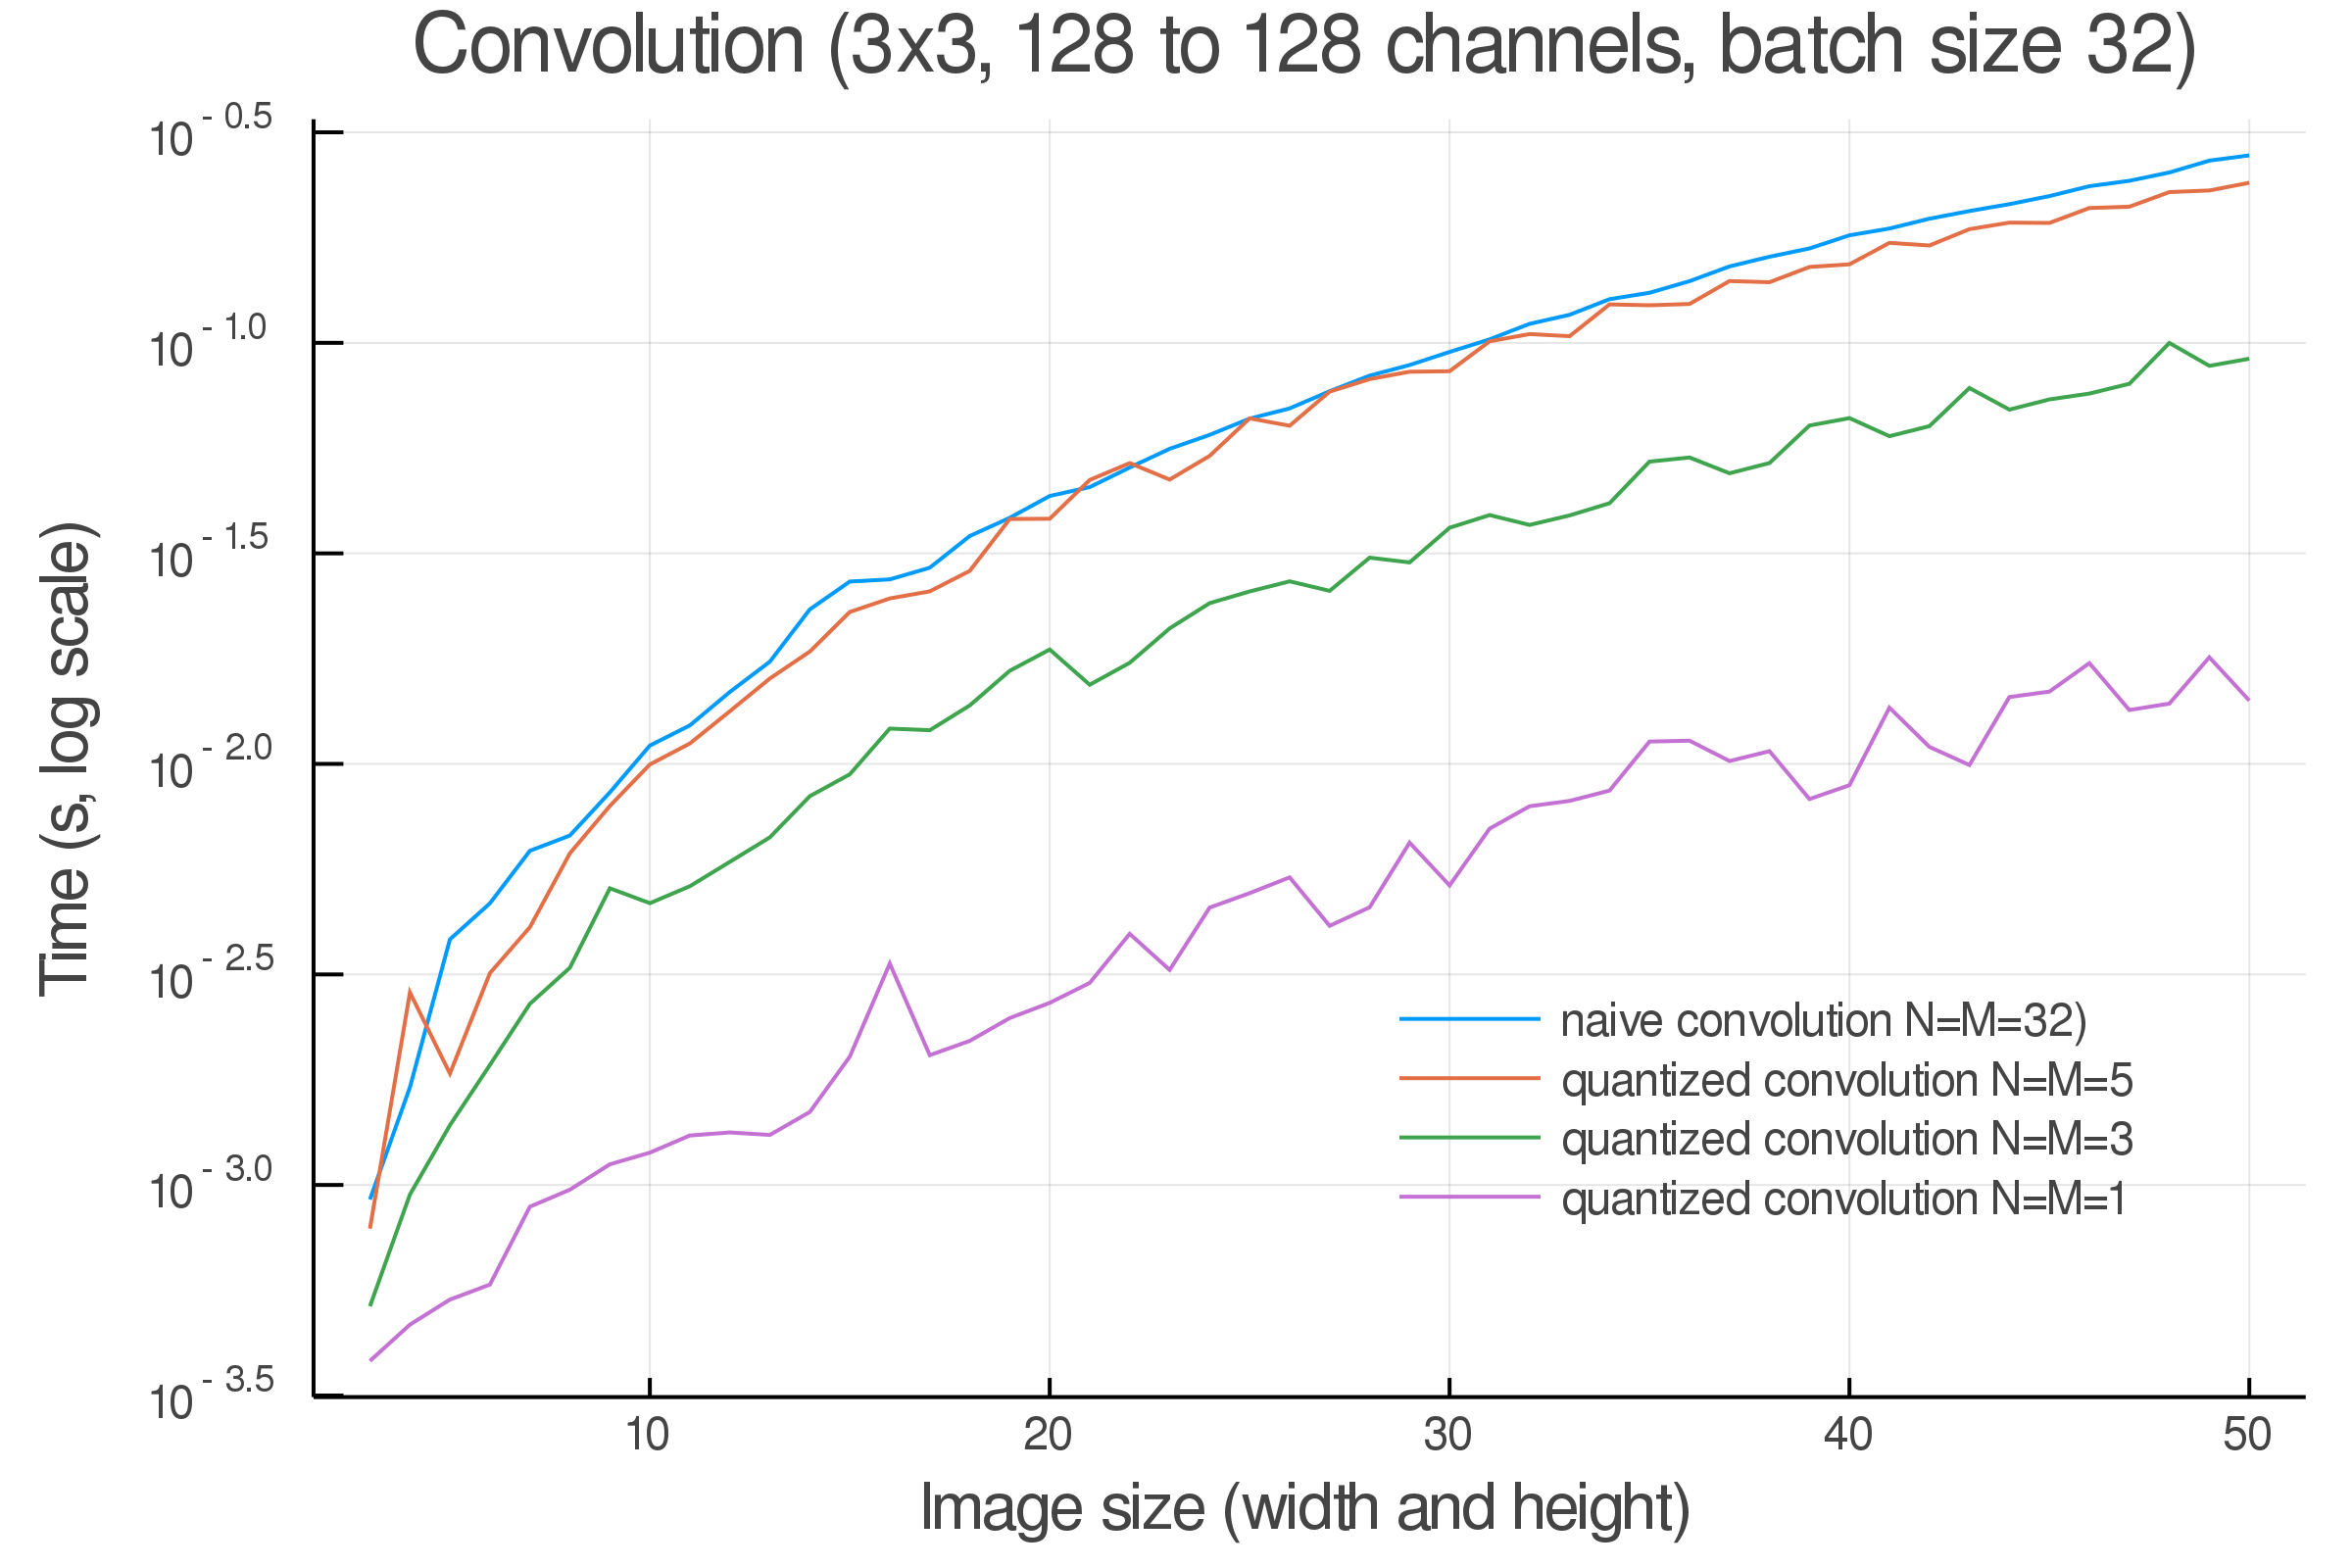

In [193]:
p = plot(range, a_naive, title="Convolution (3x3, 128 to 128 channels, batch size 32)", xlabel="Image size (width and height)",
    ylabel="Time (s, log scale)", label="naive convolution N=M=32)", yscale=:log10, format=:png, dpi=400, legend=:bottomright, background_color_legend=nothing,
    foreground_color_legend=nothing)
plot!(p, range, a_qconv55, label="quantized convolution N=M=5")
plot!(p, range, a_qconv33, label="quantized convolution N=M=3")
plot!(p, range, a_qconv11, label="quantized convolution N=M=1")

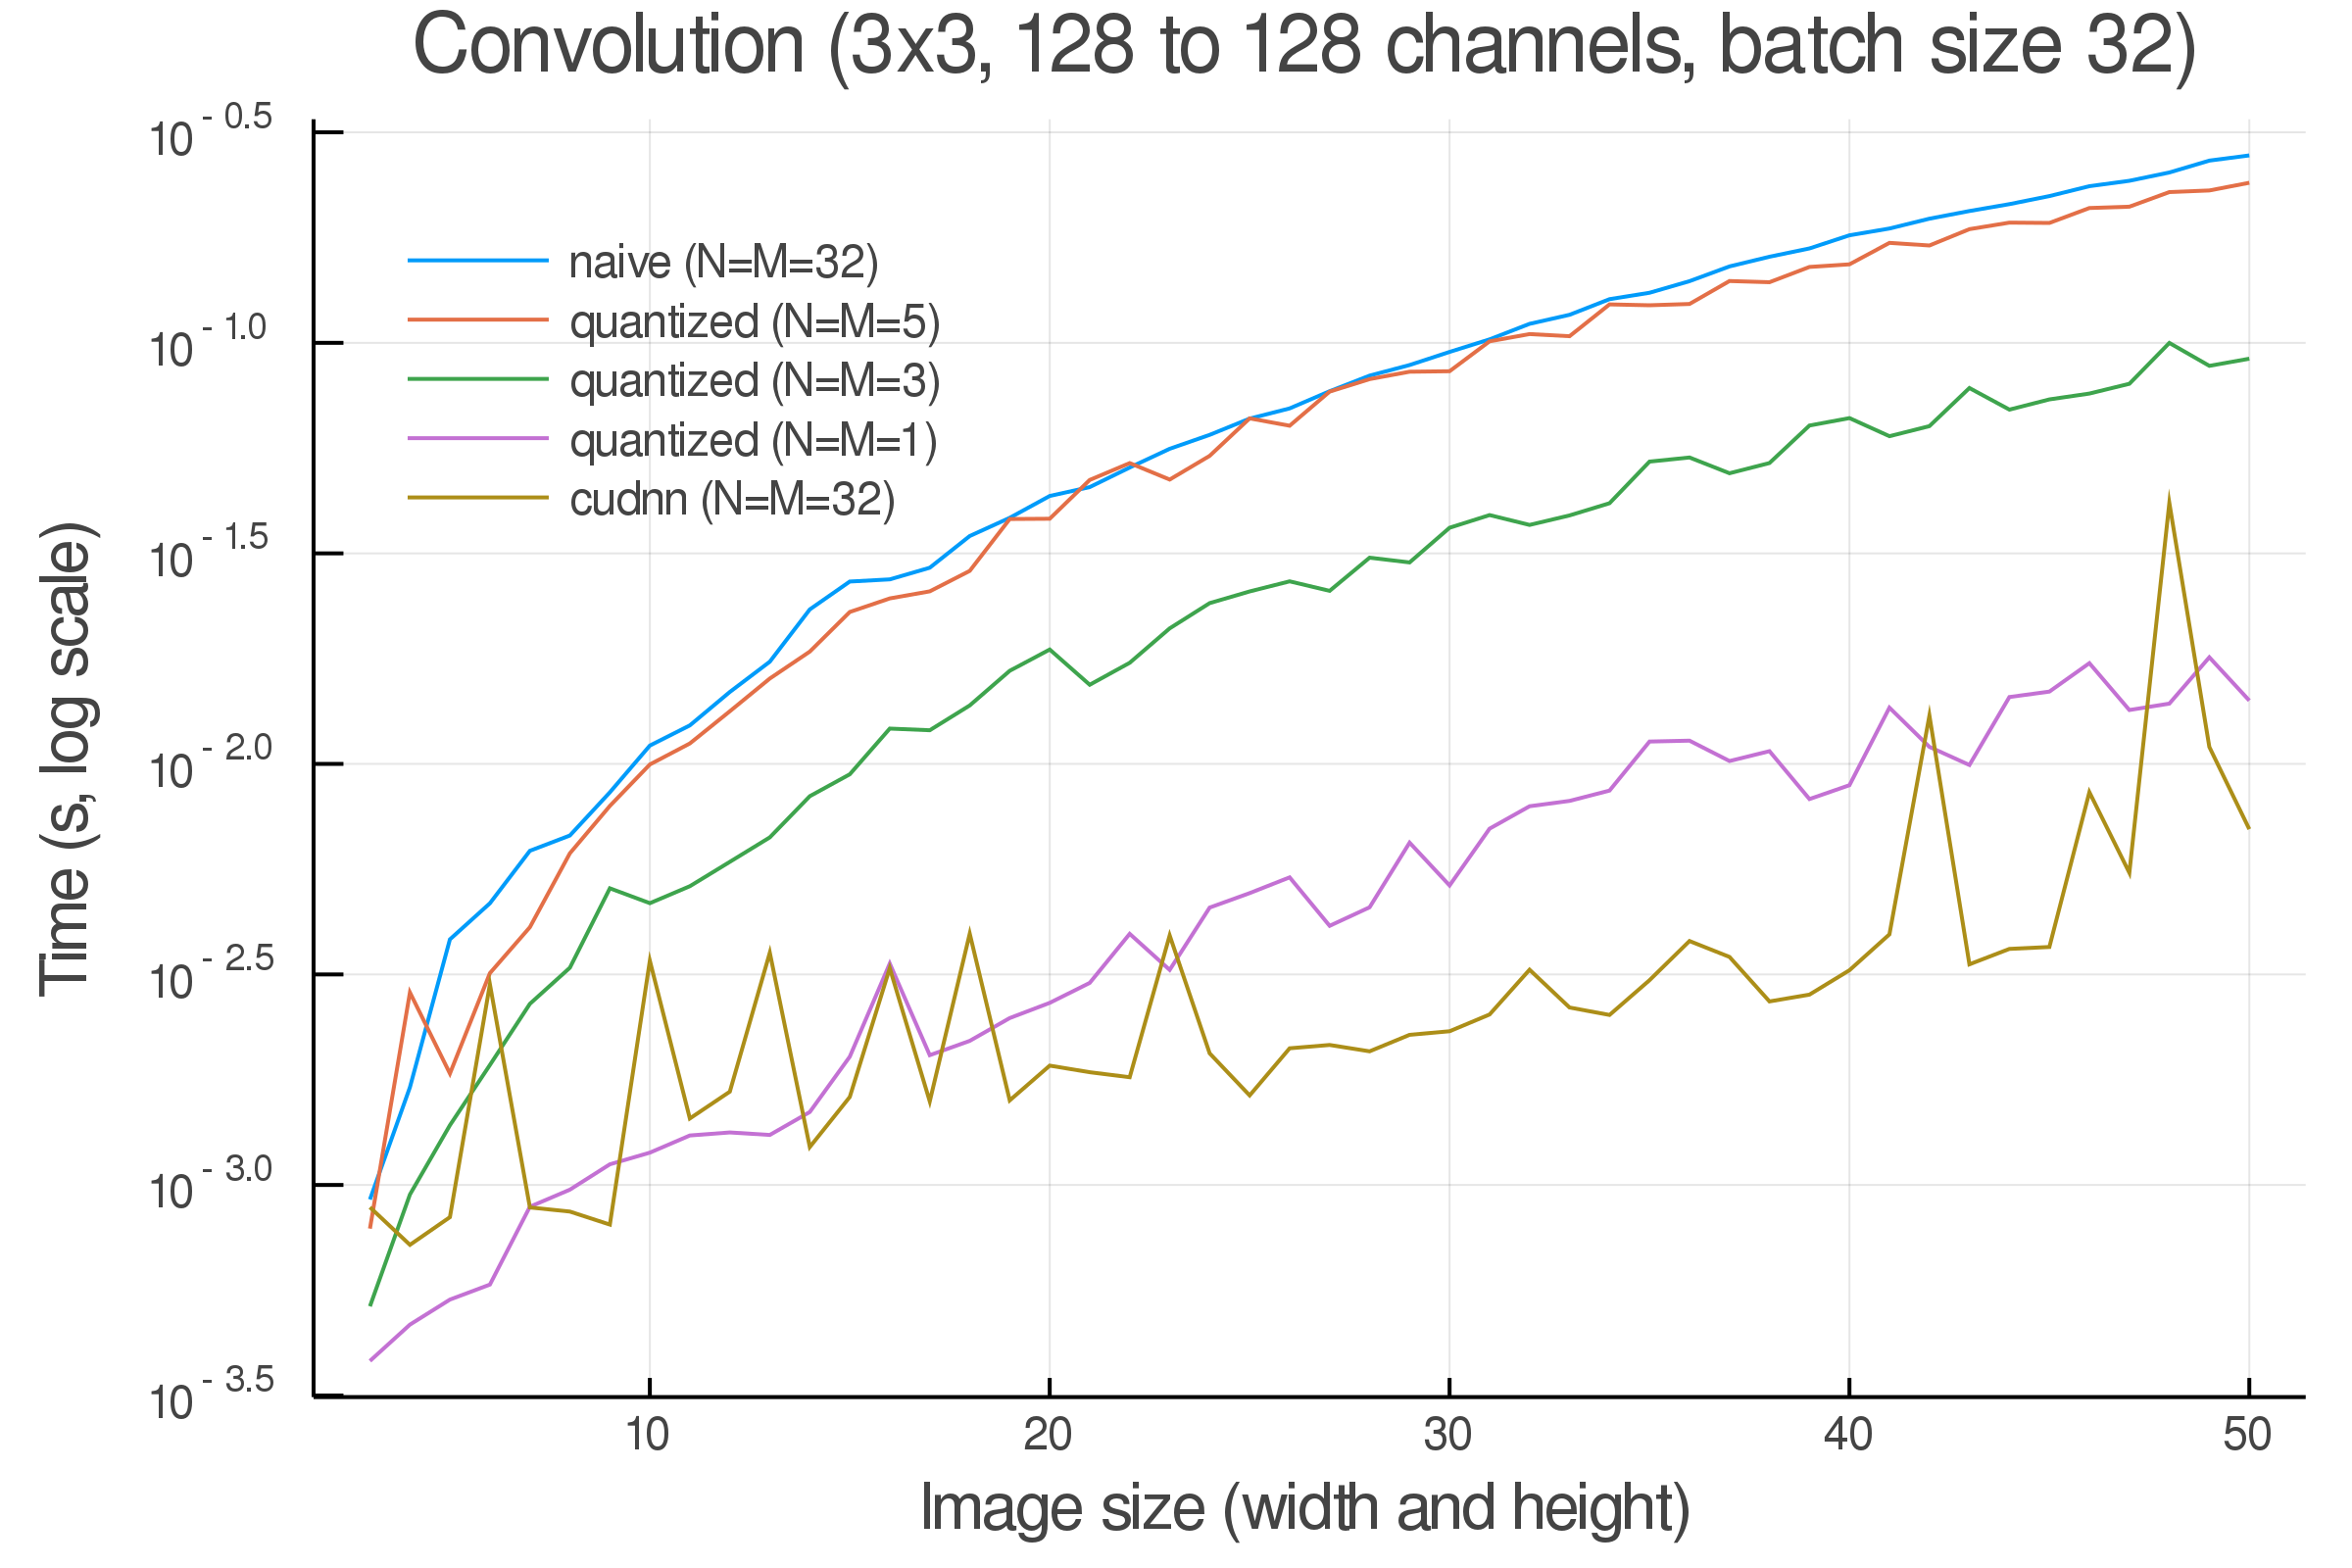

In [194]:
p = plot(range, a_naive, title="Convolution (3x3, 128 to 128 channels, batch size 32)", xlabel="Image size (width and height)",
    ylabel="Time (s, log scale)", label="naive (N=M=32)", yscale=:log10, format=:png, dpi=400, legend=:topleft, background_color_legend=nothing,
    foreground_color_legend=nothing)
plot!(p, range, a_qconv55, label="quantized (N=M=5)")
plot!(p, range, a_qconv33, label="quantized (N=M=3)")
plot!(p, range, a_qconv11, label="quantized (N=M=1)")
plot!(p, range, a_cudnn, label="cudnn (N=M=32)")